# Векторная База Данных Milvus

### Идея этого проекта заключается в том, чтобы разработать семантический поиск отзывов о банках

### 1. Устанавливаем docker с официального сайта: https://www.docker.com/

### 2. Устанавливаем конфигурационный файл (см. https://milvus.io/docs/install_standalone-docker-compose.md):
#### $ wget https://github.com/milvus-io/milvus/releases/download/v2.4.5/milvus-standalone-docker-compose.yml -O docker-compose.yml

### 3. Запускаем контейнер:
#### $ docker compose up -d

### Если все правильно то, контейнер отобразиться в Docker'е
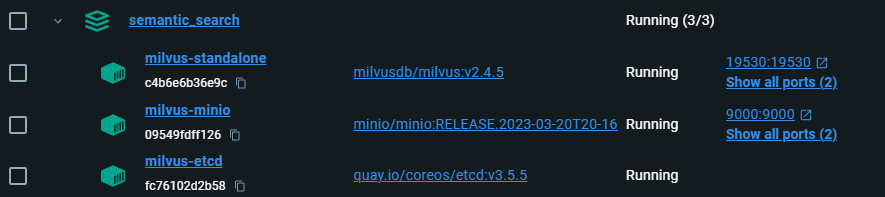

### Теперь нужно подумать над архитектурной нашей БД. Буду текст разбивать на чанки для лучшего поиска. И для того, чтобы не хранить всю информацию о тексте (его эмбеддинг, чанки и эмбеддинги чанков), буду придерживаться следующей архитектуры:
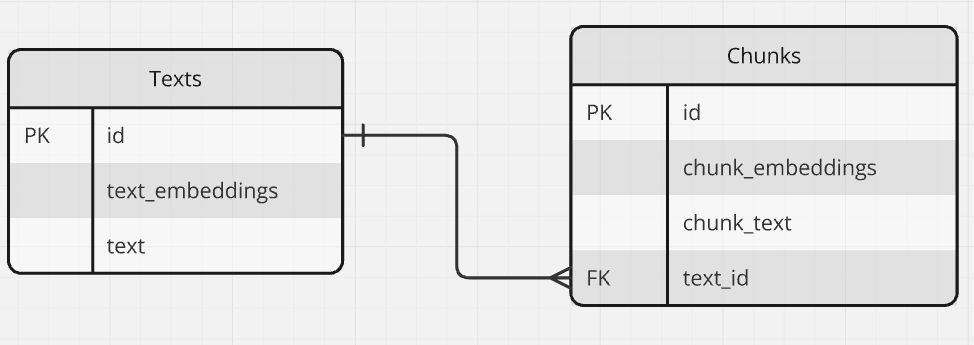

### Также заранее нужно подумать какой энкодер будет использоваться и узнать размер эмбеддингов в этой модели. Буду использовать paraphrase-multilingual-MiniLM-L12-v2, у которой размер вектора - 384

#### Почему эта модель? Она достаточно хорошо себя показывает в бенчмаркетах (см. https://github.com/avidale/encodechka) и ее размер оптимальный

### Импортируем необходимые библиотеки

In [1]:
from pymilvus import (
    connections,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    MilvusException
)
from sentence_transformers import SentenceTransformer
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm import tqdm
import json

d:\my\github\semantic_search\.venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


### Подключаемся к БД

In [2]:
connections.connect("default", host="localhost")

### Создаем поля схемы Texts

In [3]:
text_fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False), # Отключим автоматическое создание ID, чтобы самим формировать зависимости между текстом и его чанками
    FieldSchema(name="text_embeddings", dtype=DataType.FLOAT_VECTOR, dim=384),
    FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=65355)
]
text_schema = CollectionSchema(text_fields, "Texts")

### Создаем поля схемы Chunks

In [4]:
chunk_fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="chunk_embeddings", dtype=DataType.FLOAT_VECTOR, dim=384),
    FieldSchema(name="chunk_text", dtype=DataType.VARCHAR, max_length=1000),
    FieldSchema(name="text_id", dtype=DataType.INT32)
]
chunk_schema = CollectionSchema(chunk_fields, "Chunks")

### Создаем коллекцию Text_collection

In [5]:
text_collection = Collection("text_collection", text_schema)

### Создаем коллекцию Chunk_collection

In [6]:
chunk_collection = Collection("chunk_collection", chunk_schema)

### Параметры индексации

In [7]:
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2", # Метрика поиска L2
    "params": {
        "nlist": 5 # Количество "соседей"
    }
}

### Индексируем коллекции

In [8]:
text_collection.create_index(
  field_name="text_embeddings",
  index_params=index_params,
  index_name="text_index"
)

Status(code=0, message=)

In [9]:
chunk_collection.create_index(
  field_name="chunk_embeddings",
  index_params=index_params,
  index_name="chunk_index"
)

Status(code=0, message=)

### Считываем наши данные об отзывах банков

In [10]:
df = pd.read_csv('banks.csv', sep='\t')

In [11]:
df.head()

,idx,Score,Text
0,0,Positive,В Альфа-Банке работает замечательная девушка -...
1,1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,2,Positive,Очень порадовала оперативность работы в банке....
3,3,Negative,Имела неосторожность оформить потреб. кредит в...
4,4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...


### Загружаем эмбеддинговую модель

In [12]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Формируем документы

In [13]:
docs = df['Text'].tolist()

### Разбиваем текст на чанки

In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100,
                                               chunk_overlap=50)

text_chunks = []

for doc in docs:
    text_chunks.append(text_splitter.split_text(doc))

### Вот так выглядит пример разбиения

In [15]:
text_chunks[0]

['В Альфа-Банке работает замечательная девушка - Ильясова Орна, вежливая, отзывчивая, действительно',
 'Орна, вежливая, отзывчивая, действительно участвует в запросе клиента, я приходила к ней подряд',
 'в запросе клиента, я приходила к ней подряд ровно три дня, каждый день она помнила время моего',
 'три дня, каждый день она помнила время моего прихода, помогла оформить кредит в размере 1млн',
 'прихода, помогла оформить кредит в размере 1млн рублей, когда я пришла с партнером (передавать ей',
 'рублей, когда я пришла с партнером (передавать ей полученный кредит за покупаемый мною авто),',
 'ей полученный кредит за покупаемый мною авто), специалист Ильясова Орна помогла нам вывести всю',
 'специалист Ильясова Орна помогла нам вывести всю сумму в один день (а это было непросто), так что',
 'сумму в один день (а это было непросто), так что сделка состоялась и все остались довольны! Моя',
 'сделка состоялась и все остались довольны! Моя знакомая в конце всего добавила: Теперь я \xa0понял

### Формируем данные для Text_collection

In [ ]:
%time

texts_data = []
text_id_counter = 1

for doc in tqdm(docs):
    vector = model.encode(doc).tolist()

    entry = {'id': text_id_counter, 'text': doc, 'text_embadding': vector}
    text_id_counter += 1
    
    texts_data.append(entry)

#### Время выполнения: 14:26

In [ ]:
with open('data/text_data.json', 'w', encoding='utf-8') as json_file:
    json.dump(texts_data, json_file, indent=2, ensure_ascii=False)

### Формируем данные для Chunk_collection

In [ ]:
%time

text_id_counter = 1
chunks_data = []

for doc in tqdm(text_chunks):
    for chunk in doc:
        vector = model.encode(chunk).tolist()
        entry = {'chunk_embadding': vector, 'chunk_text': chunk, 'text_id': text_id_counter}

        chunks_data.append(entry)

    text_id_counter += 1

#### Время выполнения: 4:15:11 :D

In [16]:
chunks_counter = 0

for text_chunk in text_chunks:
    chunks_counter += len(text_chunk)

print(chunks_counter)

444810


In [ ]:
with open('data/chunks_data.json', 'w', encoding='utf-8') as json_file:
    json.dump(chunks_data, json_file, indent=2, ensure_ascii=False)

### Загружаем данные из JSON файлов

#### Будем частями считывать данные и загружать их в БД, потому что данные в сумме весят 4,6 ГБ

In [18]:
for i in range(1, 3):
    with open(f'data/texts_data_{i}.json', 'r', encoding='utf-8') as json_file:
        texts_data = json.load(json_file)
        text_collection.insert(texts_data)
        text_collection.flush()

In [20]:
for i in range(1, 45):
    with open(f'data/chunks_data_{i}.json', 'r', encoding='utf-8') as json_file:
        chunks_data = json.load(json_file)
        chunk_collection.insert(chunks_data)
        chunk_collection.flush()

### Подгружаем коллекции

In [21]:
text_collection.load()

In [22]:
chunk_collection.load()

### Создаем функцию поиска

In [23]:
def search(user_input): # Пользовательский запрос
    try:
        user_vector = model.encode(user_input).tolist() # Формируем эмбеддинги пользовательского запроса

        search_params = {
            "metric_type": "L2",
            "offset": 0,
            "ignore_growing": False,
            "params": {"nprobe": 5}
        } # Поисковые параметры

        similarity_search_result = chunk_collection.search(
            data=[user_vector], # Пользовательские данные
            anns_field="chunk_embeddings", # По какому полю ищем
            param=search_params,
            limit=5, # Количество выводов 
            output_fields=['text_id', 'chunk_text'] # Что выводим 
        )

        for idx, hit in enumerate(similarity_search_result[0]):
            score = hit.distance
            text_id = hit.entity.text_id
            chunk_text = hit.entity.chunk_text

            text_collection_search = text_collection.query(
                f"id=={text_id}", # Ищем по FK нужный текст 
                output_fields=['text'], 
                offset=0,
                limit=1
            ) # Обращаемся к другой коллекции (text_collection)

            for idx_text, hit_text in text_collection_search[0].items():
                if type(hit_text) == str:
                    print(f"{idx + 1}. {text_id} \nchunk_text: {chunk_text}\ntext: {hit_text} \n(distance: {score})")

    except MilvusException as e:
        print(e)
    finally:
        connections.disconnect(alias="localhost")

In [30]:
user_input = 'девушка в альфа банке'

search(user_input)

1. 13490 
chunk_text: сотрудником отдела взыскания задолженности банка. Девушка представляется Альфа-банком и спрашивает
text: Бесконечные звонки на домашний телефон.Недоброго вам дня.Вот уже несколько дней мою семью терроризируют звонками ваши сотрудники. С раннего утра и до позднего вечера. На домашнем телефоне раздается звонок. После этого происходит соединение с сотрудником отдела взыскания задолженности банка. Девушка представляется Альфа-банком и спрашивает постороннего незнакомого мне человека, некий гражданин Чернов. Звонили вчера вечером, вежливо объяснила, что такого человека не знаю. Сегодня за последние 2 часа позвонили 3 раза, устала объяснять, что такого человека не знаю. Звучит обещание исключить мой номер из списка обзвона. Но... через час снова раздается звонок и все по новой.Нервы на пределе. Отключила звук на домашнем телефоне. Мне теперь из-за вас номер телефона менять? НЕ ЗНАЮ Я ТАКОГО ЧЕЛОВЕКА! Сколько будет продолжаться это безобразие?! 
(distance: 5.580706596374

### Поиск осуществляется за 0,1 секундну, что очень даже хорошо!

# Заключение
### Как можно улучшить данный семантический поиск?
- уменьшение / увелечение чанков
- выбор другой эмбеддинговой модели (например, paraphrase-multilingual-mpnet-base-v2)
- больше данных
- выбор других параметров индексации
- выбор других параметров поиска